### Spectrum Analysis Model Training, Optimization with OpenVino and Inference on Intel Neural Compute Stick2

Run the `setupvars.bat` before calling `jupyter notebook`.
```
C:\Users\richa\IntelSWTools\openvino_2019.1.148\bin\setupvars.bat
```
Or in Linux
add the following line to `~/.bashrc`
```
source ~/bin/setupvars.sh
```

For some steps, ipython kernel will **restart** before preceding to mimic a fresh start.


### Training --> Given a .csv file of spectrum inputs (signal strength vs. frequency), train/generate a Keras `.h5` model that can correctly classify these signals

In [1]:
### You can choose to Run or Run All (by opening the command palette above)
### To run a 2nd time, use the Kernel pulldown menu and select "Restart and Run All";  

In [2]:
##########  IMPORT THE ROUTINES  ##########
###
### This section imports routines that will be needed later when the file runs
###
### Import numpy ('num-pie'), a python routine that provides a large set of numeric datatypes that you can use 
### to construct arrays.  Numpy tries to guess a datatype when you create an array, but functions that construct 
### arrays usually also include an optional argument to explicitly specify the datatype.
import numpy as np 
### Import pandas...it takes data (like a CSV or TSV file, or a SQL database) and creates a Python object 
### with rows and columns called data frame that looks very similar to table in a statistical software
import pandas as pd
### Import pyplot....matplotlib's plotting framework. That specific import line imports the module 
### "matplotlib.pyplot" and binds that to the name "plt".  There are many ways to import in Python....
import matplotlib.pyplot as plt
### Use'ggplot', a common plot style, there are others....
plt.style.use('ggplot')
### %matplotlib inline is a function that decorates a cell in a Jupyter notebook.
### You can't use it outside of jupyter notebook, and ipython console
### It seems to run fine in jupyter notebook;  in Spyder I had to add a section break after this line....
%matplotlib inline  
### To work with the Requests library in Python, you must import the requests module. 
import requests
### Python has a built-in package called re, which can be used to work with Regular Expressions.
import re
### Seaborn is a library for making statistical graphics in Python. 
#####################import seaborn
import seaborn as sns
### Import the tensorflow package
import tensorflow as tf
### Keras is a high-level interface for neural networks that runs on top of multiple backends.  Keras quickly 
### gained traction after its introduction and in 2017, the Keras API was integrated into core Tensorflow as tf.keras
from tensorflow import keras
### Scikit-learn (formerly scikits.learn) is a free software machine learning library for the Python programming 
### language. It features various classification, regression and clustering algorithms including support vector 
### machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the 
### Python numerical and scientific libraries NumPy and SciPy. The iris dataset is a classic and very easy multi-class 
### classification dataset.
from sklearn.datasets import load_iris
### Split arrays or matrices into random train and test subsets
### Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) 
### and application to input data into a single call for splitting 
### (and optionally subsampling) data in a oneliner.
from sklearn.model_selection import train_test_split
### Encode categorical integer features as a one-hot numeric array.
### Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
##########  IMPORT THE DATA  ##########
###
### This section imports a .csv file (a convenient format for when we use an actual spectrum analyzer)
###
### My proposed format is as follows:
###
### ROWS:
### Row 1: Header Row of Frequency (inputs) and Classification "Species" (output)
### All Subsequent Rows:  Individual Spectrum Input
###     For training, this is all of the data taken to date, presently 150 rows (can/will add more in the future)
###     For inference, this is the latest incoming piece of data, that is, 1 row of data
### COLUMNS:
### Columns 1:  Minimum Signal Strength in 64 bins, from -38.75 MHz (relative to on-channel center frequency)
### Columns 2:  Maximum Signal Strength in 64 bins, from -38.75 MHz (relative to on-channel center frequency)
### Columns 3:  Average Signal Strength in 64 bins, from -38.75 MHz (relative to on-channel center frequency)
### Columns 4-6:  Min/Max/Avg @ -37.5 MHz (relative to on-channel center frequency)
### Columns 7-9:  Min/Max/Avg @ -36.25 MHz (relative to on-channel center frequency)
### Columns 190-192:  Min/Avg/Max @ +40 MHz (relative to on-channel center frequency)
### Columns 193:  Output Classification, presently 3 possibilities (Spectrum Good vs. Cosite vs. Overload)
###
### This results in a file that is 151 Rows by 193 Columns
###
### The 'size' of the data is 150 x 192
###
### More specifically, the data is 150 x 64 x 3
###
### Later, we'll 'reshape' the 64 frequencies to an 8 x 8 matrix, in order to use some standard image processing routines
###
### This results in the model training (below) having the input shape of 150 x 8 x 8 x 3  
###
### Similarly, the inference (looking at the latest data) will have the input shape of 1 x 8 x 8 x 3
###
### We can easily make this more granular/detailed going forward (more data, more classificaitons, etc.)
###
### Reference http://www.insightsbot.com/blog/2CrCd3/tensorflow-tutorial-iris-classification-with-sgd
### Reference https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
### C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master\
filename = "spectrumtraintest_uhf_3d_64_80MHzsimdata2x.csv" #################################################################################
print ('filename =', filename) ### simply prints the filename
### Once the file has been downloaded, load it into memory.
### Reference https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
dataset = pd.read_csv(filename)
# dataset.head() ### simply shows the first 5 rows, to make that everyhting is OK
print(dataset.iloc[0:5,0:12])  ### shows just the first several rows and columns
#print(dataset)
numrows=dataset.shape[0]
print('numrows =', numrows)
numcols=dataset.shape[1]-1
print('numcols =', numcols)

filename = spectrumtraintest_uhf_3d_64_80MHzsimdata2x.csv
   m38.75a  m38.75b  m38.75c  m37.5a  m37.5b  m37.5c  m36.25a  m36.25b  \
0   -38.75   -38.75   -38.75   -37.5   -37.5   -37.5   -36.25   -36.25   
1  -101.00  -100.00  -100.00  -100.0  -100.0  -100.0  -100.00  -100.00   
2  -100.00  -100.00  -100.00  -100.0  -100.0  -100.0  -100.00  -100.00   
3  -100.00  -100.00  -100.00  -100.0  -100.0  -100.0  -100.00  -100.00   
4   -99.00  -100.00  -100.00  -100.0  -100.0  -100.0  -100.00  -100.00   

   m36.25c   m35a   m35b   m35c  
0   -36.25  -35.0  -35.0  -35.0  
1  -100.00 -100.0 -100.0 -100.0  
2  -100.00 -100.0 -100.0 -100.0  
3  -100.00 -100.0 -100.0 -100.0  
4  -100.00 -100.0 -100.0 -100.0  
numrows = 1153
numcols = 192


In [4]:
##########  PLOT THE INPUT DATA (optional) ##########
###
### This optional section allows us to visualize it using the seaborn visualization library. 
### With the pairplot function we can visualize the pairwise combination of features for each species.
### Reference https://seaborn.pydata.org/generated/seaborn.pairplot.html
# seaborn.pairplot(dataset, hue="species", height=2, diag_kind="kde")
# plt.show() ### plt.show() starts an event loop, looks for all currently active figure objects,
### and opens one or more interactive windows that display your figure or figures.
import time
times = []
ts1 = time.gmtime()
print(time.strftime("%Y-%m-%d %H:%M:%S",ts1))

2019-10-01 15:45:14


In [5]:
#colors = {'Spectrum Good':'r','Cosite Blocking':'g','Overload':'b','Cosite Noise Floor':'c','Cosite Reciprocal Mixing':'m','Cosite Rx Prot':'y','NA':'w'}
## create a figure and axis
#fig, ax = plt.subplots()
#fig.set_size_inches(12,8)
#for i in range(len(dataset['centera'])):
#    ax.scatter(dataset['centera'][i], dataset['p10a'][i],color=colors[dataset['species'][i]])
## set a title and labels
#ax.set_title('Dataset')
#ax.set_xlabel('centera')
#ax.set_ylabel('p10a')
#ax.legend(dataset['species'][1])

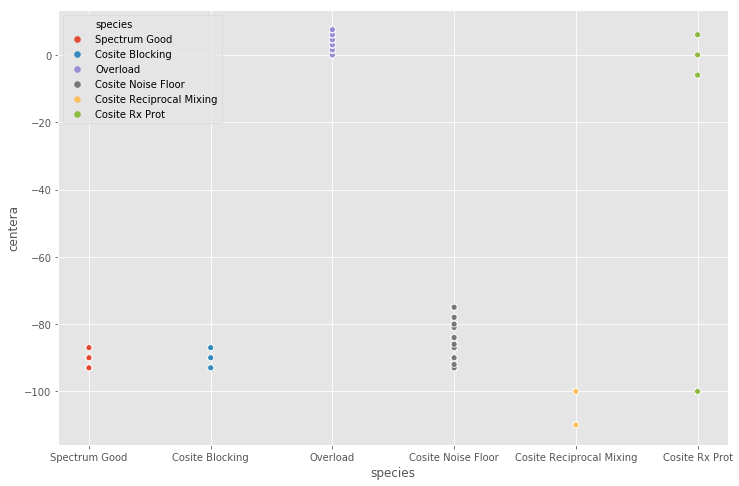

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.scatterplot(x='species', y='centera', hue='species', data=dataset)

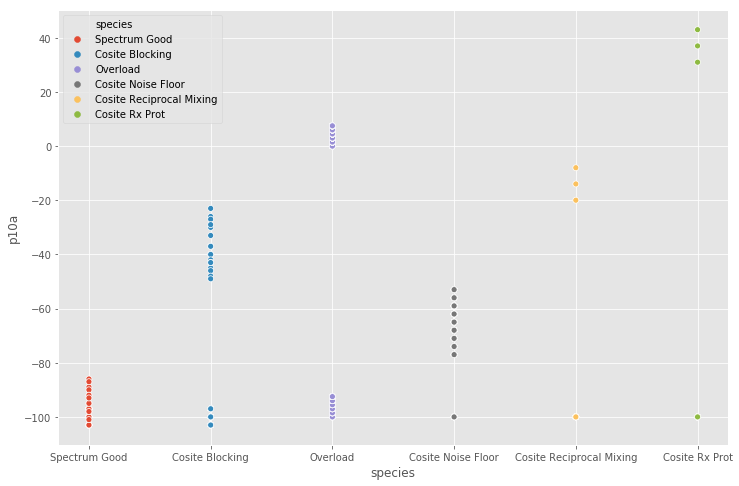

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.scatterplot(x='species', y='p10a', hue='species', data=dataset)

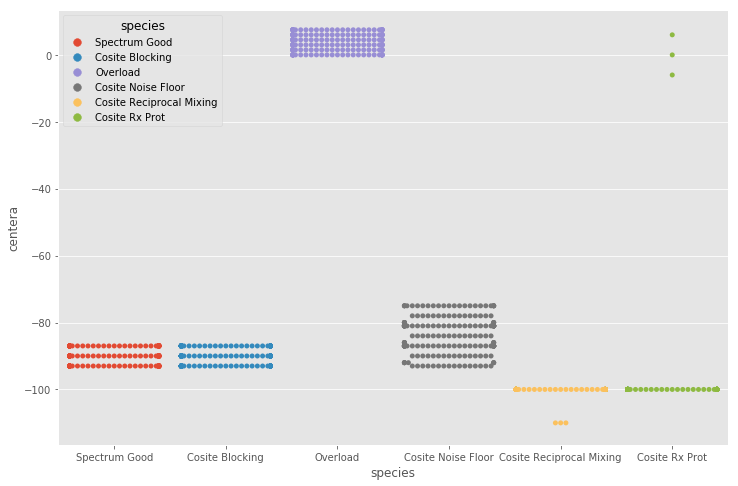

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.swarmplot(x='species', y='centera', hue='species', data=dataset)

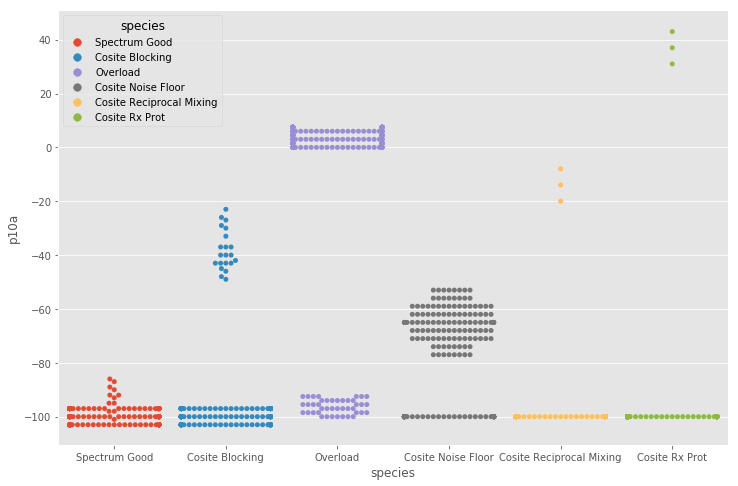

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.swarmplot(x='species', y='p10a', hue='species', data=dataset)

In [10]:
###fig, ax = plt.subplots()
###fig.set_size_inches(12,8)
###sns.swarmplot(x='p10a', y='species', hue='species', data=dataset[0:10])

In [11]:
###fig, ax = plt.subplots()
###fig.set_size_inches(12,8)
####print(dataset.head)
###print(dataset.iloc[0,0:10])
####print(dataset.iloc[0])
####df.iloc[1,0:10]
####sns.swarmplot(x=dataset.iloc[0,0:10], y=dataset.iloc[1,0:10], hue='species', data=dataset[0:10])
###sns.swarmplot(x=dataset.iloc[0,0:10], y=dataset.iloc[1,0:10])

In [12]:
###fig, ax = plt.subplots()
###fig.set_size_inches(12,8)
###plt.plot(dataset.iloc[0,0:9], dataset.iloc[1,0:9])

In [13]:
###fig, ax = plt.subplots()
###fig.set_size_inches(12,8)
###plt.scatter(dataset.iloc[0,0:192], dataset.iloc[1,0:192])

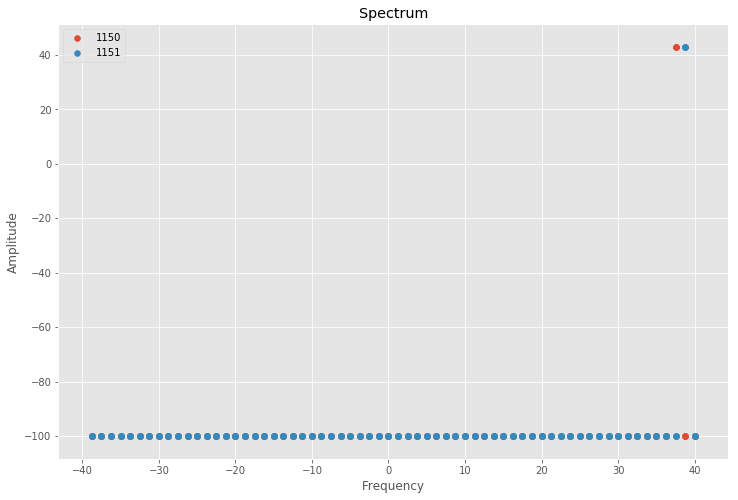

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
#for i in range[1:10]:
#for i in range([1:5]):
#    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
plt.scatter(dataset.iloc[0,0:192], dataset.iloc[1150,0:192])
plt.scatter(dataset.iloc[0,0:192], dataset.iloc[1151,0:192])
ax.set_title('Spectrum')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
ax.legend()

Text(0, 0.5, 'Amplitude')

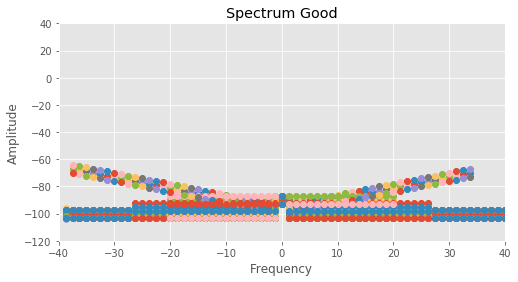

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(1,192):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Spectrum Good')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()

Text(0, 0.5, 'Amplitude')

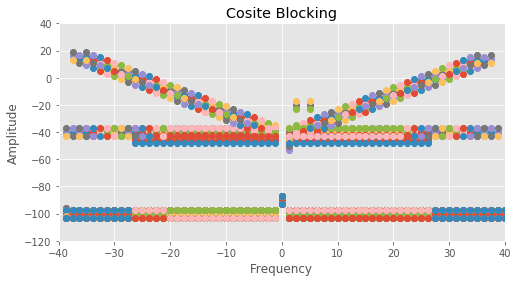

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(193,384):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Cosite Blocking')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()

Text(0, 0.5, 'Amplitude')

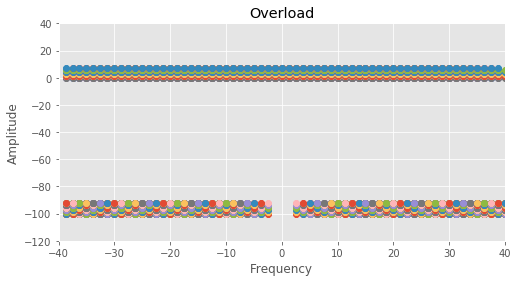

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(385,576):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Overload')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()

Text(0, 0.5, 'Amplitude')

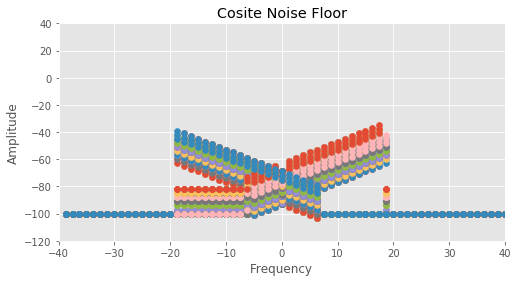

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(577,768):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Cosite Noise Floor')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()


Text(0, 0.5, 'Amplitude')

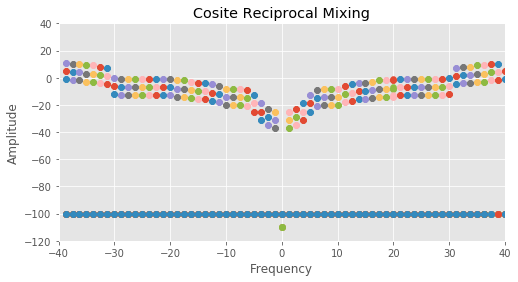

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(769,960):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Cosite Reciprocal Mixing')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()

Text(0, 0.5, 'Amplitude')

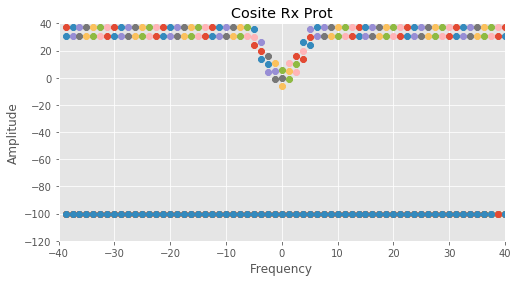

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
plt.axis([-40, 40, -120, 40])
#for i in range[1:10]:
for i in range(961,1152):
    plt.scatter(dataset.iloc[0,0:192], dataset.iloc[i,0:192])
ax.set_title('Cosite Rx Prot')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
#ax.legend()

In [21]:
###fig, ax = plt.subplots()
###fig.set_size_inches(12,8)
###d = {'columns': ['T', 'G', 'C', '-', 'A', 'C', 'T', '-', 'A', 'G', 'T', 
###                 '-', 'A', 'G', 'C', '-', 'A', 'T', 'G', 'C'],
###     'data': [[97, 457, 178, 75, 718, 217, 193, 69, 184, 198,
###               777, 65, 100, 143, 477, 54, 63, 43, 55, 47]],
###     'index': [1]}
###df = pd.DataFrame(d['data'], columns=d['columns'], index=d['index'])
###df.columns.names = ['SAMPLE']
####
###row = df.iloc[0]
###row.plot(kind='line')
###plt.show()

In [22]:
####fig, ax = plt.subplots()
####fig.set_size_inches(12,8)
####df1 = pd.DataFrame(dataset.T[0:3], columns=dataset.T[0:2], index=[1])
###df1 = pd.DataFrame(dataset.iloc[1,0:10], columns=dataset.iloc[0,0:10], index=[0])
#############df1 = pd.DataFrame(dataset.T[0:3], index=[1])
#############df1 = pd.DataFrame(dataset.T, index=[1])
###df1.columns.names = ['FREQ']
####
###row = df1.iloc[0]
###row.plot(kind='line')
###plt.show()

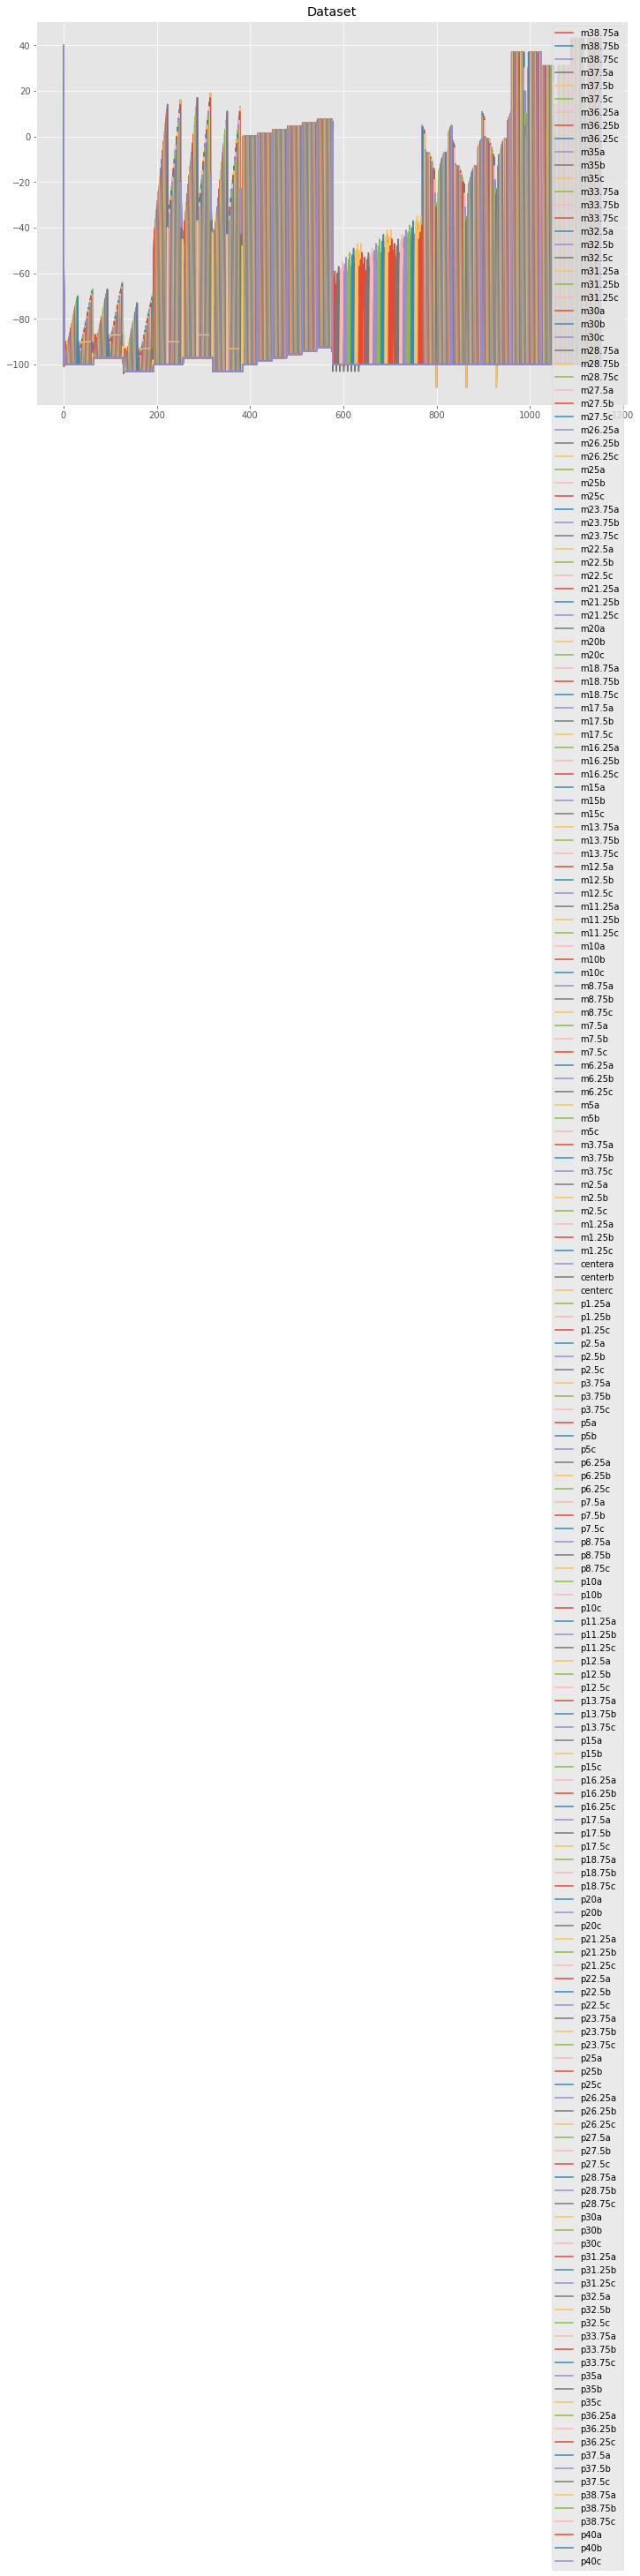

In [23]:
# get columns to plot
dataset1 = dataset.T
columns = dataset.columns.drop('species')
# create x data
x_data = range(0, dataset.shape[0])
# create figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
# plot each column
for column in columns:
    ax.plot(x_data, dataset[column])
# set title and legend
ax.set_title('Dataset')
ax.legend()

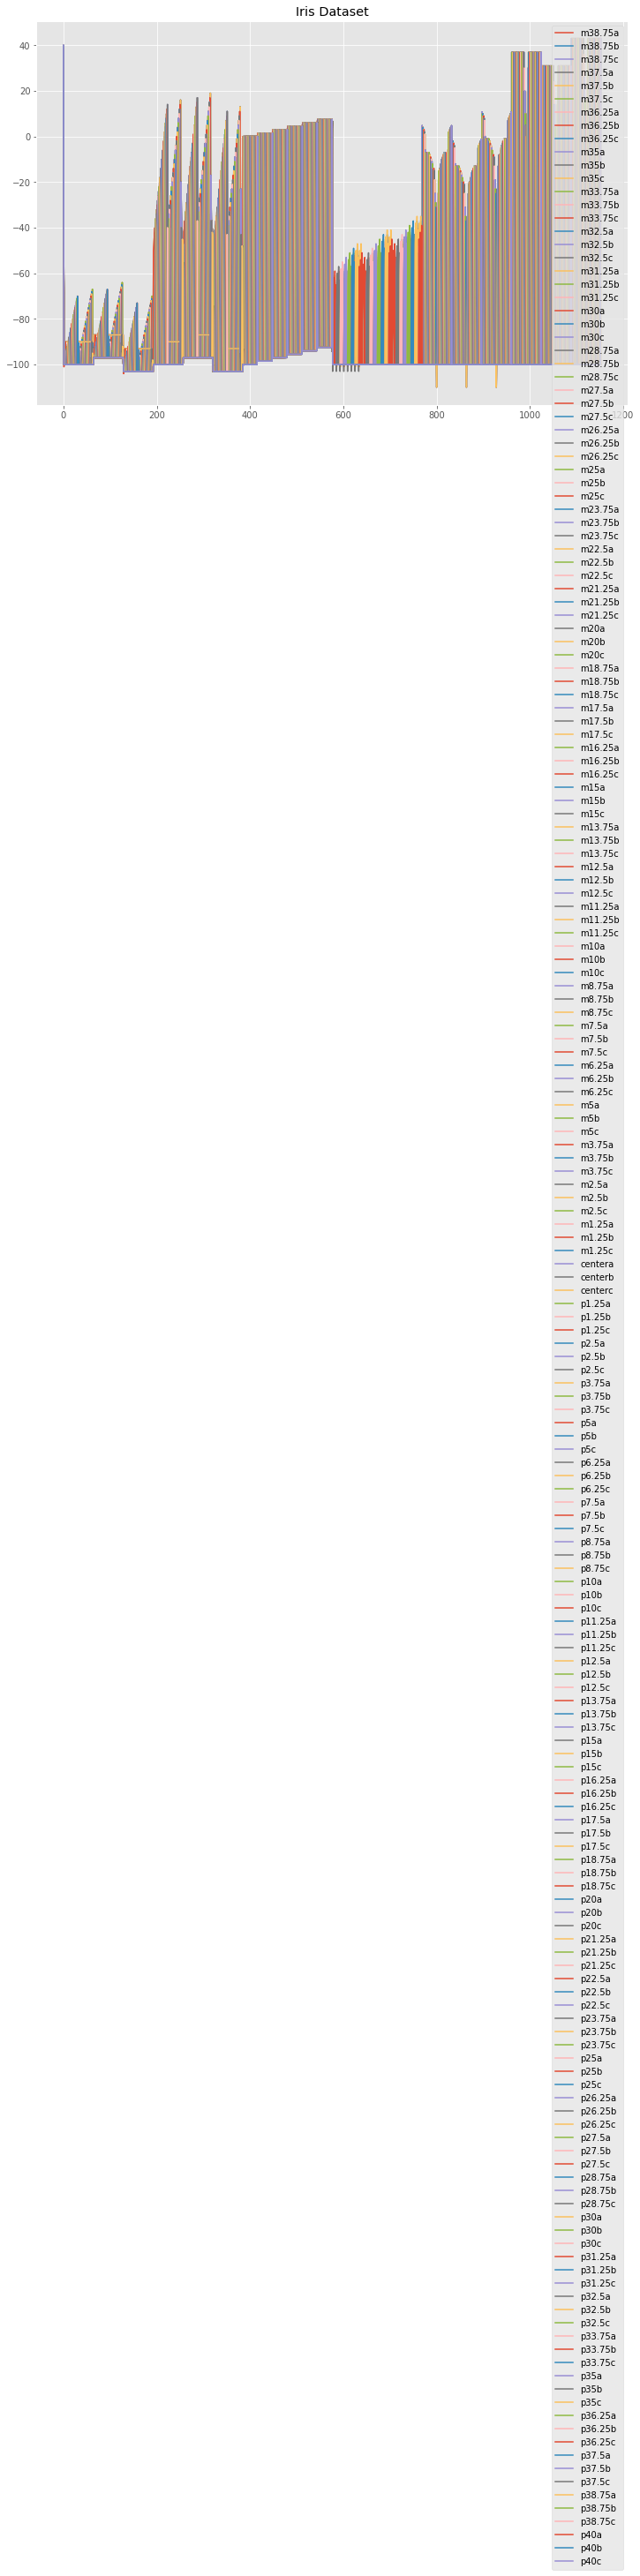

In [24]:
# get columns to plot
columns = dataset.columns.drop(['species'])
# create x data
x_data = range(0, dataset.shape[0])
# create figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
# plot each column
for column in columns:
    ax.plot(x_data, dataset[column])
# set title and legend
ax.set_title('Iris Dataset')
ax.legend()

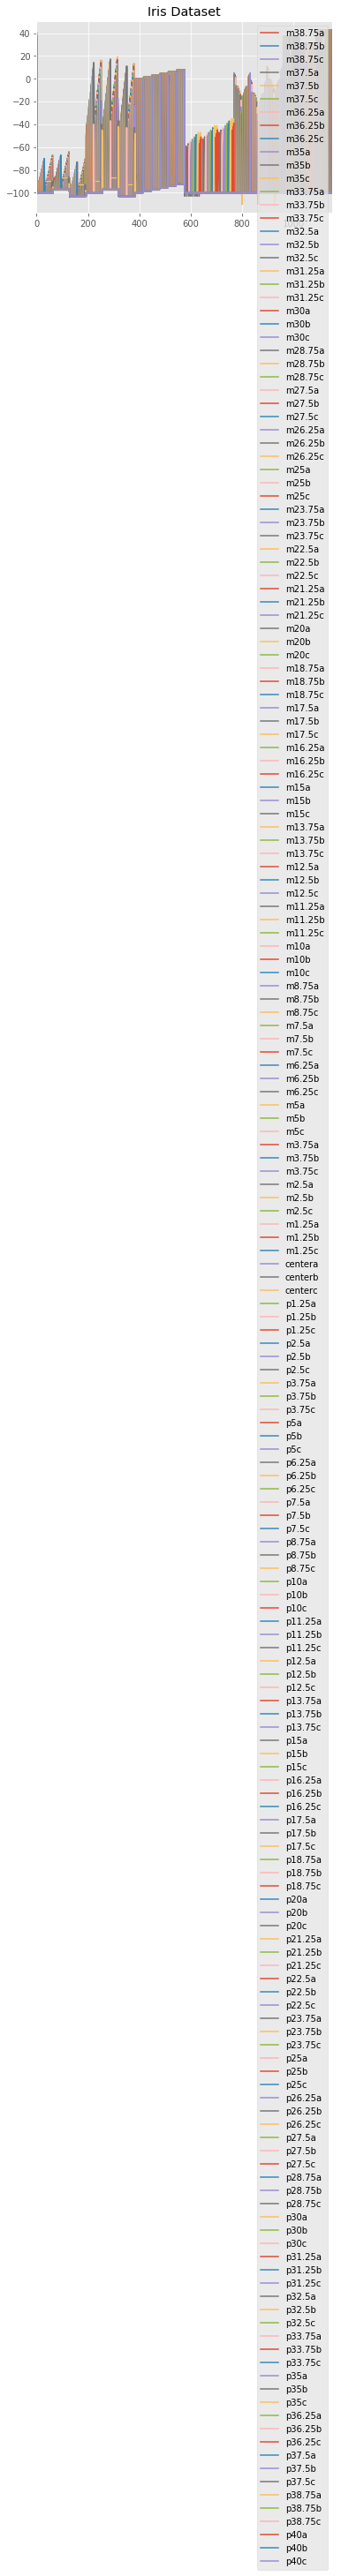

In [25]:
#dataset.drop(['species'], axis=1).plot.line(title='Iris Dataset')
dataset.drop(['species'], axis=1).plot.line(title='Iris Dataset')

C:\Users\richa\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\richa\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


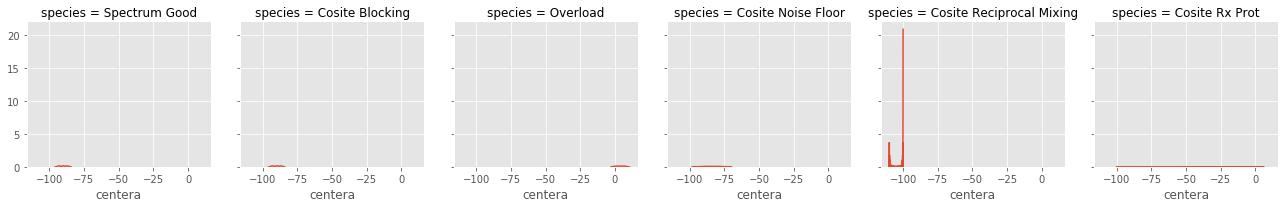

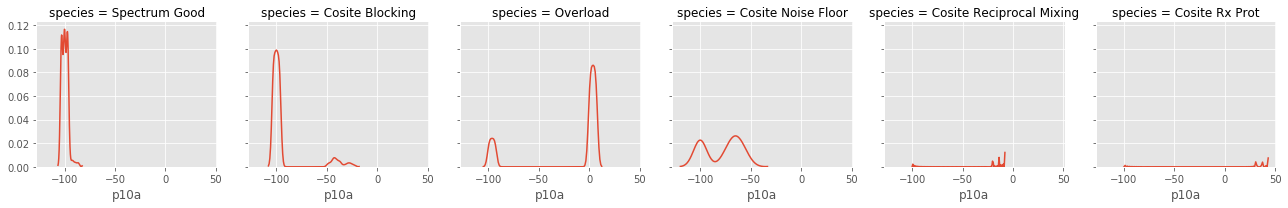

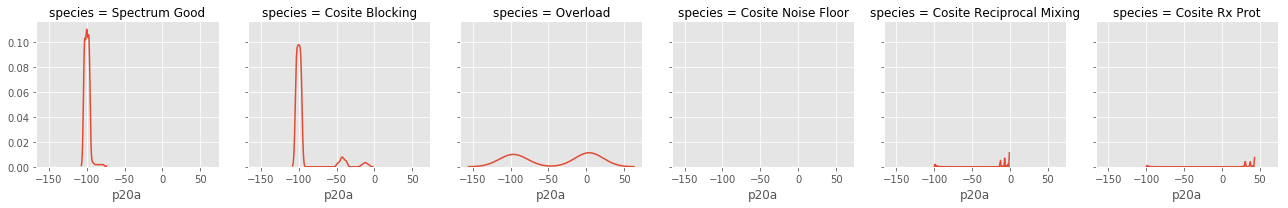

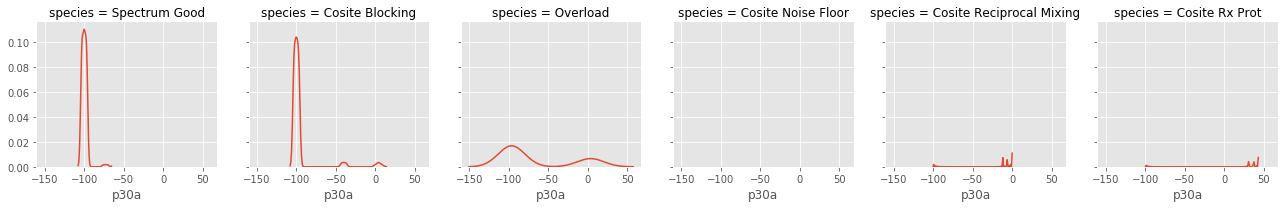

In [26]:
g = sns.FacetGrid(dataset, col='species')
g = g.map(sns.kdeplot, 'centera')
#
g10 = sns.FacetGrid(dataset, col='species')
g10 = g10.map(sns.kdeplot, 'p10a')
#
g20 = sns.FacetGrid(dataset, col='species')
g20 = g20.map(sns.kdeplot, 'p20a')
#
g30 = sns.FacetGrid(dataset, col='species')
g30 = g30.map(sns.kdeplot, 'p30a')

In [27]:
filename = "spectrumtraintest_uhf_3d_64_80MHzsimdata2y.csv" #################################################################################
print ('filename =', filename) ### simply prints the filename
### Once the file has been downloaded, load it into memory.
### Reference https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
dataset = pd.read_csv(filename)
# dataset.head() ### simply shows the first 5 rows, to make that everyhting is OK
print(dataset.iloc[0:5,0:12])  ### shows just the first several rows and columns
#print(dataset)
numrows=dataset.shape[0]
print('numrows =', numrows)
numcols=dataset.shape[1]-1
print('numcols =', numcols)

filename = spectrumtraintest_uhf_3d_64_80MHzsimdata2y.csv
   m38.75a  m38.75b  m38.75c  m37.5a  m37.5b  m37.5c  m36.25a  m36.25b  \
0   -101.0   -100.0   -100.0  -100.0  -100.0  -100.0   -100.0   -100.0   
1   -100.0   -100.0   -100.0  -100.0  -100.0  -100.0   -100.0   -100.0   
2   -100.0   -100.0   -100.0  -100.0  -100.0  -100.0   -100.0   -100.0   
3    -99.0   -100.0   -100.0  -100.0  -100.0  -100.0   -100.0   -100.0   
4   -100.0   -100.0   -100.0  -100.0  -100.0  -100.0   -100.0   -100.0   

   m36.25c   m35a   m35b   m35c  
0   -100.0 -100.0 -100.0 -100.0  
1   -100.0 -100.0 -100.0 -100.0  
2   -100.0 -100.0 -100.0 -100.0  
3   -100.0 -100.0 -100.0 -100.0  
4   -100.0 -100.0 -100.0 -100.0  
numrows = 1152
numcols = 192


In [28]:
##########  PERFORM ONE HOT ENCODING  ##########
###
### We must one-hot encode the species column from text into a vector that our machine learning algorithm will 
### understand --> Example:  [0 1 0], that is, all zeros and a '1' that maps to the classification.
### "One-hot" is a group of bits among which the legal combinations of values are only those with a
### single high bit and all the others low. To do so, use the LabelBinarizer class from the scikit learn package. 
### After calling the fit_transform method, Y will be a one hot encoded vector.
### Reference https://scikit-learn.org/stable/modules/generated/
### sklearn.preprocessing.label_binarize.html#sklearn.preprocessing.label_binarize
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Y = species_lb.fit_transform(dataset.species.values) 
### 150 x 3 matrix, that denotes the correct classifier as a '1' in the correct column
print('Output Prediction Y =',Y[0:102,0:6])  ### shows just the first 102 rows and 3 columns, else print(Y) 
#print('Output Prediction Y =',Y[1:103,0:6])  ### shows just the first 102 rows and 3 columns, else print(Y) 
y2 = species_lb.inverse_transform(Y)  
### my attempt to transform it back, as a double check
print('Output Classification y2',y2[0:102])  ### shows just the first 101 rows, else print(y2)
#print('Output Classification y2',y2[1:103])  ### shows just the first 101 rows, else print(y2)

Output Prediction Y = [[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0

In [29]:
##########  NORMALIZE THE INPUT DATA  ##########
###
### To improve gradient descent, we will normalize the input values utilizing the normalize class from scikit learn. 
### X_data1 variable will contain our normalized features we will use to train our neural network.
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURES = dataset.columns[0:numcols] ###
X_data = dataset[FEATURES].as_matrix()
print ('X_data =',X_data[0:5,0:3])
print (X_data.shape)
X_scaled = normalize(X_data) ### normalize first 5 columns ('X_data')
print ('X_scaled =',X_scaled[0:5,0:3])
print (X_scaled.shape)
### For convenience, reshaping each input row into a '3d' representation allow use of many image processing routines
### 150 Rows of Training Samples x 64 spectrum inputs (converted to 8 x 8 'image') x 3 spectrum states (avg/max/min)
X_scaled3d = X_scaled.reshape((numrows,2,32,3))  ###################################################################
print ('X_scaled3d =',X_scaled3d[0:5,0:3])
print (X_scaled3d.shape)

X_data = [[-101. -100. -100.]
 [-100. -100. -100.]
 [-100. -100. -100.]
 [ -99. -100. -100.]
 [-100. -100. -100.]]
(1152, 192)
X_scaled = [[-0.07299508 -0.07227235 -0.07227235]
 [-0.07230964 -0.07230964 -0.07230964]
 [-0.07235278 -0.07235278 -0.07235278]
 [-0.07166389 -0.07238777 -0.07238777]
 [-0.07233143 -0.07233143 -0.07233143]]
(1152, 192)
X_scaled3d = [[[[-0.07299508 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.07227235 -0.07227235]
   [-0.07227235 -0.0722723

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [30]:
##########  MAP THE INPUT AND OUTPUT TO REAL-WORLD NAMES  ##########
###
### This section maps the inputs and outputs to names that people can understand
names=['Cosite Blocking', 'Cosite Noise Floor', 'Cosite Reciprocal Mixing', 'Cosite Rx Prot', 'Spectrum Good', 'Overload'] ### changed classification names for spectrum
feature_names = list(dataset.columns)  ### input feature_names for spectrum
print ('names = ',names)
print ('feature_names = ',feature_names)

names =  ['Cosite Blocking', 'Cosite Noise Floor', 'Cosite Reciprocal Mixing', 'Cosite Rx Prot', 'Spectrum Good', 'Overload']
feature_names =  ['m38.75a', 'm38.75b', 'm38.75c', 'm37.5a', 'm37.5b', 'm37.5c', 'm36.25a', 'm36.25b', 'm36.25c', 'm35a', 'm35b', 'm35c', 'm33.75a', 'm33.75b', 'm33.75c', 'm32.5a', 'm32.5b', 'm32.5c', 'm31.25a', 'm31.25b', 'm31.25c', 'm30a', 'm30b', 'm30c', 'm28.75a', 'm28.75b', 'm28.75c', 'm27.5a', 'm27.5b', 'm27.5c', 'm26.25a', 'm26.25b', 'm26.25c', 'm25a', 'm25b', 'm25c', 'm23.75a', 'm23.75b', 'm23.75c', 'm22.5a', 'm22.5b', 'm22.5c', 'm21.25a', 'm21.25b', 'm21.25c', 'm20a', 'm20b', 'm20c', 'm18.75a', 'm18.75b', 'm18.75c', 'm17.5a', 'm17.5b', 'm17.5c', 'm16.25a', 'm16.25b', 'm16.25c', 'm15a', 'm15b', 'm15c', 'm13.75a', 'm13.75b', 'm13.75c', 'm12.5a', 'm12.5b', 'm12.5c', 'm11.25a', 'm11.25b', 'm11.25c', 'm10a', 'm10b', 'm10c', 'm8.75a', 'm8.75b', 'm8.75c', 'm7.5a', 'm7.5b', 'm7.5c', 'm6.25a', 'm6.25b', 'm6.25c', 'm5a', 'm5b', 'm5c', 'm3.75a', 'm3.75b', 'm3.75c'

In [31]:
##########  SPLIT THE DATA INTO A TRAINING SET (train the model) AND A TEST SET (evaluate the model)  ##########
###
### The conventional way to train a network is to use some of the data for training, and a second set of data
### for testing the model
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled3d, Y, test_size=0.5, random_state=2) ##########
### n_features = X.shape[1]
#n_features = X_scaled3d.shape[1]
n_features = X_scaled3d.shape
n_features = numcols  ####
n_classes = Y.shape[1]
print ('n_features =',n_features)  ### Confirming the number of input features
print ('n_classes =',n_classes)  ### Confirming the nubmer of output classifications

n_features = 192
n_classes = 6


In [32]:
##########  DISABLE WARNING MESSAGES (optional) ##########
###
### Re-using this section to ignore FutureWarning messages
### Warning messages are typically issued in situations where it is useful 
### to alert the user of some condition in a program, where that condition 
### (normally) doesn’t warrant raising an exception and terminating the program. 
### For example, one might want to issue a warning when a program uses an obsolete module.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
##########  CONFIGURE THE NEURAL NETWORK MODEL  ##########
###
### The Sequential model is a linear stack of layers.
### Reference https://keras.io/getting-started/sequential-model-guide/
from keras.models import Sequential
### Dense is a densely-connected NN layer.
### Dense implements the operation: output = activation(dot(input, kernel) + bias), where activation is the 
### element-wise activation function passed as the activation argument, kernel is a weights matrix created 
### by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).
### Note: if the input to the layer has a rank greater than 2, then it is flattened prior to the 
### initial dot product with kernel.
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
###
def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        model = Sequential(name=name)
### Convolutional layer: A linear operation using a subset of the weights of a dense layer. 
### Nearby inputs are connected to nearby outputs (specifically - a convolution). The weights for the convolutions 
### at each location are shared. Due to the weight sharing, and the use of a subset of the weights of a dense layer, 
### there’s far less weights than in a dense layer. Generally followed by a non-linear activation function
### Spectrum input is 64 frequency bins with 3 amplitude measurements (Min, Max, Avg), arranged as 
### (2 rows * 32 columns * 3 amplitudes (Min, Max, Avg)....default is Min = Max = Avg
### Conv2D applies 32 convolution filters of size 1 (row) x 3 (column) each.
        model.add(Conv2D(64, (1, 3), activation='relu', input_shape=(2, 32, 3)))
### An optional additional Conv2D can provide more accurate classification; operates on the previous output shape
        model.add(Conv2D(64, (1, 3), activation='relu'))
### Pooling layer: Replace each patch in the input with a single output, which is the maximum (can also be average)
### of the input patch
        model.add(MaxPooling2D(pool_size=(2, 2))) 
### Dropout layer: Can be used to prevent overfitting (too much detail)
        model.add(Dropout(0.25))
### Flatten layer: Makes the data one-dimensional, in order to allow output classification    
        model.add(Flatten())
### Dense layer: A linear operation in which every input is connected to every output by a weight 
### (so there are n_inputs * n_outputs weights). Generally followed by a non-linear activation function
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
### Another Drouput Layer
        model.add(Dropout(0.25))
### Another Dense Layer
        model.add(Dense(output_dim, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
        return model
    return create_model

### Placeholder (for now) that potentially allows multiple models to be run with added dense layers
### 8 = number of neurons, size of the filter for each layer
### i = the number of dense layers
models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 2)]    ##########
for create_model in models:
    create_model().summary()
    
### TensorBoard is a visualization tool provided with TensorFlow. This callback writes a log for TensorBoard, 
### which allows you to visualize dynamic graphs of your training and test metrics, as well as activation 
### histograms for the different layers in your model.
from keras.callbacks import TensorBoard
history_dict = {}
# TensorBoard Callback
### A callback is a set of functions to be applied at given stages of the training procedure. 
### You can use callbacks to get a view on internal states and statistics of the model during training. 
### You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential
### or Model classes. The relevant methods of the callbacks will then be called at each stage of the training. 
cb = TensorBoard()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 30, 64)         640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 28, 64)         12352     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 14, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 14, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               229632    
___________________________

In [34]:
##########  TRAIN THE MODEL(S)  ##########
###
for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    ### Callback that records events into a History object.  This callback is automatically applied 
    ### to every Keras model. The History object gets returned by the fit method of models.
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=200,  ###########
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    ### Returns the loss value & metrics values for the model in test mode.
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', "{0:.2f}".format(score[0]))
    print('Test accuracy %:', "{0:.2f}".format(score[1]*100))
    ### Keeps a running history of models and results
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Instructions for updating:
Use tf.cast instead.
Test loss: 0.16
Test accuracy %: 96.01


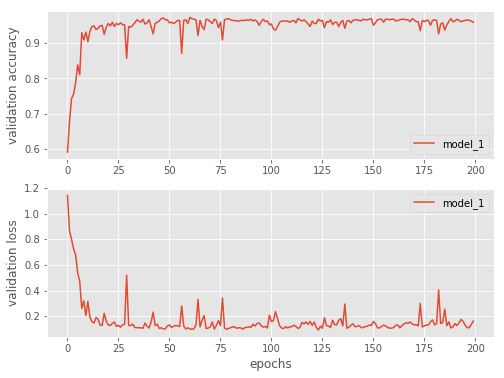

In [35]:
##########  PLOT/VISUALIZE THE RESULTS (optional)  ##########
###
### Show how the models perform (hopefully improve) vs. time/epochs
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))
for model_name in history_dict:
    val_acc = history_dict[model_name][0].history['val_acc']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_acc, label=model_name)
    ax2.plot(val_loss, label=model_name)
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

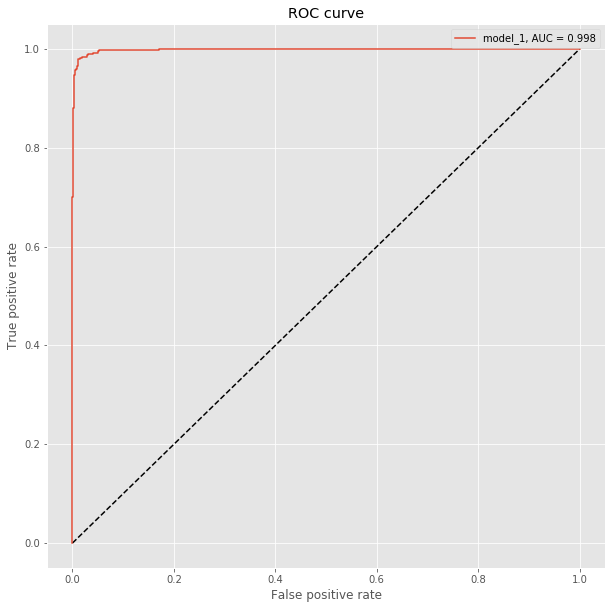

In [36]:
##########  COMPUTE THE RECEIVER OPERATING CHARACTERISTIC (ROC) (optional)  ##########
###
### Receiver Operating Characteristic (ROC) is a metric to evaluate classifier output quality.  
### ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. 
### This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, 
### and a true positive rate of one. This is not very realistic, but it does mean that a larger area under 
### the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal 
### to maximize the true positive rate while minimizing the false positive rate.
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
for model_name in history_dict:
    model = history_dict[model_name][1]
    ### Generates output predictions for the input samples.
    Y_pred = model.predict(X_test)
    ### compute ROC curve metrics
    ### fpr : array, shape = [>2]
    ### Increasing false positive rates such that element i is the false positive
    ### rate of predictions with score >= thresholds[i].
    ### tpr : array, shape = [>2]
    ### Increasing true positive rates such that element i is the true positive
    ### rate of predictions with score >= thresholds[i].
    ### thresholds : array, shape = [n_thresholds]
    ### Decreasing thresholds on the decision function used to compute fpr and
    ### tpr. thresholds[0] represents no instances being predicted and is 
    ### arbitrarily set to max(y_score) + 1.
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [37]:
##########  SAVE MODEL  ##########
###
### Save the model in .h5 format
model.save('spectrummodel_uhf_3d_64_80MHzsimdata2x.h5')    ############################################################
### C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master\
print ('model =',model)  

model = <keras.engine.sequential.Sequential object at 0x0000017A5ADD27F0>


### Inference --> Given one input and the Keras .h5 model, generate an output that predicts/classifies that input

This is the piece that runs embedded on an edge device (specifically, see NCS2 section later)....but we're going to run it on our own computer first...Note that this can be performed very fast (milliseconds for a model of moderate complexity)

In [38]:
##########  Spectrum Good Test ##########
###
filename = "spectruminference_uhf_good_3d_64_80MHzsimdata2x.csv"  ########################
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
# print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_good_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Spectrum Good']
Spectrum Good %=: 98.9
Cosite Blocking %=: 0.1
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 1.0
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [39]:
##########  Spectrum Cosite Blocking Test ##########
###
filename = "spectruminference_uhf_cosite_blocking_3d_64_80MHzsimdata2x.csv"
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
# print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_cosite_blocking_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Cosite Blocking']
Spectrum Good %=: 0.0
Cosite Blocking %=: 100.0
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [40]:
##########  Spectrum Cosite Noise Floor Test ##########
###
filename = "spectruminference_uhf_cosite_noisefloor_3d_64_80MHzsimdata2x.csv"
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
# print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_cosite_noisefloor_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Cosite Noise Floor']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 100.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [41]:
##########  Spectrum Cosite Reciprocal Mix Test ##########
###
filename = "spectruminference_uhf_cosite_recipmix_3d_64_80MHzsimdata2x.csv"
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
# print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_cosite_recipmix_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Cosite Reciprocal Mixing']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.1
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 95.4
Cosite Rx Prot %=: 4.4
Overload %=: 0.0


In [42]:
##########  Spectrum Cosite Rx Prot Test ##########
###
filename = "spectruminference_uhf_cosite_rxprot_3d_64_80MHzsimdata2x.csv"
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
# print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_cosite_rxprot_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Cosite Rx Prot']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 100.0
Overload %=: 0.0


In [43]:
##########  Spectrum Jammed Test ##########
###
filename = "spectruminference_uhf_overload_3d_64_80MHzsimdata2x.csv" ########################################
print ('filename =',filename) ### simply prints the filename
datasetinf = pd.read_csv(filename)########
numrowsinf=datasetinf.shape[0]
print('numrows =', numrowsinf)
numcolsinf=datasetinf.shape[1]-1
print('numcols =', numcolsinf)
from sklearn.preprocessing import LabelBinarizer
species_lb = LabelBinarizer()
Yinf = species_lb.fit_transform(datasetinf.species.values)
print ('Yinf =',Yinf)
Yinf.shape
y2inf = species_lb.inverse_transform(Yinf)  ### my attempt to transform it back
print ('Input Classification of Test Sample',y2inf)
### Scale input vectors individually to unit norm (vector length).
from sklearn.preprocessing import normalize
FEATURESinf = datasetinf.columns[0:numcolsinf] ###
X_datainf = datasetinf[FEATURESinf].as_matrix()
#print ('X_datainf =',X_datainf)
Xinf = normalize(X_datainf) ### X-data = X-scaled = X to match the code below
#print ('Xinf =',Xinf)
# Xinf.shape
Xinf3d = Xinf.reshape((1,2,32,3))
#print ('Xinf3d =',Xinf3d)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
Y_predinf = model.predict(Xinf3d)
#print('Predicted =:', (Y_predinf))
print('Spectrum Good %=:', "{0:.1f}".format(Y_predinf[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(Y_predinf[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(Y_predinf[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(Y_predinf[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(Y_predinf[0,3]*100))
print('Overload %=:', "{0:.1f}".format(Y_predinf[0,5]*100))

filename = spectruminference_uhf_overload_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinf = [[0]]
Input Classification of Test Sample ['Overload']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 100.0


In [44]:
##########  MEASURE HOW FAST IT RAN ##########
###
import time
times = []
for i in range(20):
    start_time = time.time()
    Y_predinf = model.predict(Xinf3d) ###########
    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1/mean_delta
print('average(milliseconds):',"{0:.3f}".format(mean_delta*1000))
print('frames per second:',"{0:.1f}".format(fps))
ts2 = time.gmtime()
print(time.strftime("%H:%M:%S",ts1))
print(time.strftime("%H:%M:%S",ts2))
# Clear any previous session.
tf.keras.backend.clear_session()

average(milliseconds): 0.598
frames per second: 1671.1
15:45:14
15:47:57


### Model Optimization using OpenVino

In [45]:
##########  FREEZE THE GRAPH  ##########
###
### Freezing is the process to identify and save all of required things(graph, weights etc) in a single file
### that you can easily use.  Need this to run OpenVino
###
### Force reset ipython namespaces
%reset -f
import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
# Clear any previous session.
tf.keras.backend.clear_session()
save_pb_dir = './model'
model_fname = './spectrummodel_uhf_3d_64_80MHzsimdata2x.h5'   ########################################################################
def freeze_graph(graph, session, output, save_pb_dir='.', save_pb_name='frozen_model_spectrum.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen
# This line must be executed before loading Keras model.
tf.keras.backend.set_learning_phase(0) 
model = load_model(model_fname)
session = tf.keras.backend.get_session()
INPUT_NODE = [t.op.name for t in model.inputs]
OUTPUT_NODE = [t.op.name for t in model.outputs]
print(INPUT_NODE, OUTPUT_NODE)
frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], save_pb_dir=save_pb_dir)

['conv2d_3_input'] ['dense_8/Softmax']
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.


In [46]:
##########  REPRINT THE MODEL (optional)  ##########
###
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2, 30, 64)         640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 28, 64)         12352     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 14, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 14, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               229632    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
__________

In [47]:
##########  GET THINGS SET UP TO RUN THE OPTIMIZER ##########
###
### Force reset ipython namespaces
%reset -f
import platform
is_win = 'windows' in platform.platform().lower()
# OpenVINO 2019
if is_win:
    mo_tf_path = '"C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo_tf.py"'
else:
    # mo_tf.py path in Linux
    mo_tf_path = '/opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py'

pb_file = './model/frozen_model_spectrum.pb'
output_dir = './model'
input_shape = [1, 2, 32, 3]       ##############
input_shape_str = str(input_shape).replace(' ', '')
print('input_shape =',input_shape_str)

input_shape = [1,2,32,3]


In [48]:
##########  RUN THE ACTUAL OPTIMIZER (one line of code) ##########
###
### Need to use python3.5+
!python {mo_tf_path} --input_model {pb_file} --output_dir {output_dir} --input_shape {input_shape_str} --data_type FP16
### Look for SUCCESS at the end of the result, something like: 
### [ SUCCESS ] Generated IR model.
### [ SUCCESS ] XML file: C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master\./model\frozen_model_spectrum.xml
### [ SUCCESS ] BIN file: C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master\./model\frozen_model_spectrum.bin
### [ SUCCESS ] Total execution time: 4.13 seconds.

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master-to-rit\./model/frozen_model_spectrum.pb
	- Path for generated IR: 	C:\Users\richa\IntelSWTools\openvino_2019.1.148\deployment_tools\demo\keras_openvino-master-to-rit\./model
	- IR output name: 	frozen_model_spectrum
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,2,32,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	

### Run Inference on the OpenVINO Inference Engine (IE), on NCS2 ("MYRIAD")


In [49]:
##########  GET THINGS SET UP TO RUN THE NEURAL COMPUTE STICK2 (NCS2)  ##########
###  
### Note:  Needs a path such as `C:\Intel\...\python\python3.5` or `~/intel/.../python/python3.5` in `PYTHONPATH`
### force reset ipython namespaces
%reset -f
import platform
import os
is_win = 'windows' in platform.platform().lower()
import numpy as np
try:
    from openvino import inference_engine as ie
    from openvino.inference_engine import IENetwork, IEPlugin
except Exception as e:
    exception_type = type(e).__name__
    print("The following error happened while importing Python API module:\n[ {} ] {}".format(exception_type, e))
    sys.exit(1)

In [50]:
##########  CHOOSE WHICH "PLUG IN" RUNS THE INFERENCE, SELECT 'MYRIAD' FOR NCS2 ##########
###
### Plugin initialization for specified device and load extensions library if specified.
plugin_dir = None
model_xml = './model/frozen_model_spectrum.xml'
model_bin = './model/frozen_model_spectrum.bin'
# Devices: GPU (intel), CPU, MYRIAD
plugin = IEPlugin("MYRIAD", plugin_dirs=plugin_dir)
#plugin = IEPlugin("GPU", plugin_dirs=plugin_dir)
net = IENetwork(model=model_xml, weights=model_bin)
assert len(net.inputs.keys()) == 1
assert len(net.outputs) == 1
input_blob = next(iter(net.inputs))
print(input_blob)
out_blob = next(iter(net.outputs))
print(out_blob)
# Load network to the plugin
exec_net = plugin.load(network=net)
del net

conv2d_3_input
dense_8/Softmax


In [51]:
##########  INFERENCE ON NCS2 ##########
###
import numpy as np 
import pandas as pd
import requests
import re
import seaborn
import tensorflow as tf
from tensorflow import keras  ### added this from plot file
filenamencs = "spectruminference_uhf_good_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
#print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
### TensorFlow format is "Channel Last", OpenVino want to see "Channel First" 
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2)) 
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_good_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
(1, 1)
['Spectrum Good']
Spectrum Good %=: 98.3
Cosite Blocking %=: 0.2
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 1.5
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [52]:
filenamencs = "spectruminference_uhf_cosite_blocking_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2))
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_cosite_blocking_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinfncs = [[0]]
(1, 1)
['Cosite Blocking']
Spectrum Good %=: 0.0
Cosite Blocking %=: 99.9
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [53]:
filenamencs = "spectruminference_uhf_cosite_noisefloor_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2))
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_cosite_noisefloor_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinfncs = [[0]]
(1, 1)
['Cosite Noise Floor']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 100.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 0.0


In [54]:
filenamencs = "spectruminference_uhf_cosite_recipmix_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2))
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_cosite_recipmix_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinfncs = [[0]]
(1, 1)
['Cosite Reciprocal Mixing']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.2
Cosite Noise Floor %=: 0.1
Cosite Reciprocal Mix %=: 97.3
Cosite Rx Prot %=: 2.4
Overload %=: 0.0


In [55]:
filenamencs = "spectruminference_uhf_cosite_rxprot_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2))
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_cosite_rxprot_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinfncs = [[0]]
(1, 1)
['Cosite Rx Prot']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 100.0
Overload %=: 0.0


In [56]:
filenamencs = "spectruminference_uhf_overload_3d_64_80MHzsimdata2x.csv" #################################################################################
print (filenamencs) ### simply prints the filename
datasetinfncs = pd.read_csv(filenamencs)
datasetinfncs.head() ### simply shows the first 5 rows, to make that everyhting is OK
#print(datasetinfncs) ### shows the entire file, to confirm number of rows & columns
numrowsinfncs=datasetinfncs.shape[0]
print('numrows =', numrowsinfncs)
numcolsinfncs=datasetinfncs.shape[1]-1
print('numcols =', numcolsinfncs)
from sklearn.preprocessing import LabelBinarizer
species_lbncs = LabelBinarizer()
Yinfncs = species_lbncs.fit_transform(datasetinfncs.species.values) ###
print ('Yinfncs =',Yinfncs)
print (Yinfncs.shape)
y2infncs = species_lbncs.inverse_transform(Yinfncs) ###
print(y2infncs)
from sklearn.preprocessing import normalize
FEATURESinfncs = datasetinfncs.columns[0:numcolsinfncs] ### changed from [0:4] for spectrum ###########
X_datainfncs = datasetinfncs[FEATURESinfncs].as_matrix()
#print(X_datainfncs)
Xinfncs = normalize(X_datainfncs) ### X-data = X-scaled = X to match the code below
#print(Xinfncs)
Xinf3dncs = Xinfncs.reshape((1,2,32,3))
Xinf3dncsx = np.transpose(Xinf3dncs, (0,3,1,2))
#print(Xinf3dncsx)
resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
#print (resncs)
res1ncs = resncs[out_blob]
#print (res1ncs)
#print('Predicted =:', (res1ncs))
print('Spectrum Good %=:', "{0:.1f}".format(res1ncs[0,4]*100))
print('Cosite Blocking %=:', "{0:.1f}".format(res1ncs[0,0]*100))
print('Cosite Noise Floor %=:', "{0:.1f}".format(res1ncs[0,1]*100))
print('Cosite Reciprocal Mix %=:', "{0:.1f}".format(res1ncs[0,2]*100))
print('Cosite Rx Prot %=:', "{0:.1f}".format(res1ncs[0,3]*100))
print('Overload %=:', "{0:.1f}".format(res1ncs[0,5]*100))

spectruminference_uhf_overload_3d_64_80MHzsimdata2x.csv
numrows = 1
numcols = 192
Yinfncs = [[0]]
(1, 1)
['Overload']
Spectrum Good %=: 0.0
Cosite Blocking %=: 0.0
Cosite Noise Floor %=: 0.0
Cosite Reciprocal Mix %=: 0.0
Cosite Rx Prot %=: 0.0
Overload %=: 100.0


In [57]:
import time
times = []
for i in range(20):
    start_time = time.time()
    resncs = exec_net.infer(inputs={input_blob: Xinf3dncsx})
    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1/mean_delta
print('average(milliseconds):',"{0:.3f}".format(mean_delta*1000))
print('frames per second:',"{0:.1f}".format(fps))
ts = time.gmtime()
print(time.strftime("%Y-%m-%d %H:%M:%S", ts))

average(milliseconds): 2.383
frames per second: 419.7
2019-10-01 15:48:09


### Complete;  Next Steps Could Include More Better Input Data, Better Model, Better Tradeoff of Speed vs. Performance